In [1]:
import tensorflow as tf

# List all physical devices of type GPU
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        gpu_details = tf.config.experimental.get_device_details(gpu)
        gpu_name = gpu_details.get('device_name', 'Unknown GPU')
        print(f"Found a GPU with ID: {gpu}, Name: {gpu_name}")
else:
    print("Failed to detect a GPU.")


Found a GPU with ID: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from tensorflow.keras.models import load_model

# Ensure Pillow is installed
!pip install Pillow

import PIL  # Ensure Pillow is imported

In [3]:
!pip install scikit-learn
!pip install matplotlib
!pip install h5py
!pip install scikit-plot
!pip install seaborn

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, Dropout, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

In [5]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Set global mixed precision policy
mixed_precision.set_global_policy('mixed_float16')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4050 Laptop GPU, compute capability 8.9


In [6]:
# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = tf.nn.tanh(tf.tensordot(x, self.W, axes=[-1, 0]) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=[-1, 0]), axis=1)
        attention_weights = tf.expand_dims(attention_weights, axis=-1)
        weighted_sum = x * attention_weights
        return weighted_sum

# Residual Block
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Custom CNN Model with EfficientNetB0 as base
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=2):
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # Make sure the residual block matches the base model output shape
    x = residual_block(x, x.shape[-1])
    x = residual_block(x, 256)
    x = residual_block(x, 512)

    x = AttentionLayer()(x)  # Apply attention mechanism here

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
custom_cnn_model = build_custom_cnn()
custom_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_cnn_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb0 (Functional)    (None, 7, 7, 1280)   4049571     ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 7, 7, 1280)   14746880    ['efficientnetb0[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 7, 7, 1280)  5120        ['conv2d[0][0]']             

In [7]:
# Data Augmentation and Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

data_aug_train = ImageDataGenerator(
    height_shift_range=0.15,
    width_shift_range=0.15,
    rotation_range=10,
    shear_range=0.1,
    fill_mode='nearest',
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator()  # You forgot to define this too

train_generator = data_aug_train.flow_from_directory(
    r"G:\Reliability Check Dataset\Deepfake Dataset\real_vs_fake\real-vs-fake\train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    classes=['fake', 'real'],
    seed=2,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    r"G:\Reliability Check Dataset\Deepfake Dataset\real_vs_fake\real-vs-fake\valid",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    classes=['fake', 'real'],
    seed=2,
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    r"G:\Reliability Check Dataset\Deepfake Dataset\real_vs_fake\real-vs-fake\test",
    target_size=(224, 224),
    batch_size=205,
    class_mode='categorical',
    color_mode='rgb',
    classes=['fake', 'real'],
    shuffle=False
)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


Found 102041 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [8]:
import PIL
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from tensorflow.keras.models import load_model

In [9]:
# Train the model
history = custom_cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20,
    callbacks=[reduce_lr, early_stopping]
)

# Fine-tune the base model by unfreezing some layers
base_model = custom_cnn_model.layers[1]  # Accessing the base model from the custom model
base_model.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
custom_cnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model
history_fine = custom_cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,
    callbacks=[reduce_lr, early_stopping]
)

# Save the best model
custom_cnn_model.save('best_model.h5')


Epoch 1/20
3188/3188 [==============================] - 2560s 796ms/step - loss: 0.4063 - accuracy: 0.8185 - val_loss: 0.2946 - val_accuracy: 0.8769 - lr: 0.0010
Epoch 2/20
3188/3188 [==============================] - 2434s 763ms/step - loss: 0.3059 - accuracy: 0.8725 - val_loss: 0.4540 - val_accuracy: 0.7961 - lr: 0.0010
Epoch 3/20
3188/3188 [==============================] - 2365s 742ms/step - loss: 0.2592 - accuracy: 0.8945 - val_loss: 0.2237 - val_accuracy: 0.9111 - lr: 0.0010
Epoch 4/20
3188/3188 [==============================] - 2291s 719ms/step - loss: 0.2272 - accuracy: 0.9084 - val_loss: 0.1763 - val_accuracy: 0.9309 - lr: 0.0010
Epoch 5/20
3188/3188 [==============================] - 2403s 754ms/step - loss: 0.2032 - accuracy: 0.9185 - val_loss: 0.1710 - val_accuracy: 0.9380 - lr: 0.0010
Epoch 6/20
3188/3188 [==============================] - 2293s 719ms/step - loss: 0.1840 - accuracy: 0.9271 - val_loss: 0.1819 - val_accuracy: 0.9289 - lr: 0.0010
Epoch 7/20
3188/3188 [======

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [18]:
final_train_acc = history_fine.history['accuracy'][-1]
print(f"Final Training Accuracy (fine‑tune): {final_train_acc:.4f}")


Final Training Accuracy (fine‑tune): 0.9952


In [21]:
# if your test generator is actually called `test_generator`, do:
test_steps = test_generator.samples // test_generator.batch_size

test_loss, test_accuracy = custom_cnn_model.evaluate(
    test_generator,
    steps=test_steps,
    verbose=1
)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss:     {test_loss:.4f}")


97/97 [==============================] - 218s 2s/step - loss: 0.0703 - accuracy: 0.9760
Test Accuracy: 0.9760
Test Loss:     0.0703


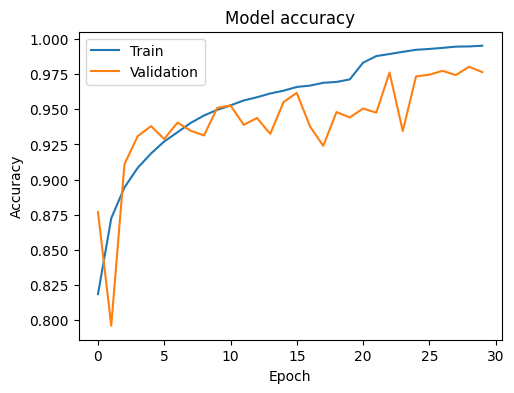

In [11]:
# Train vs validation validation accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

98/98 [==============================] - 186s 2s/step


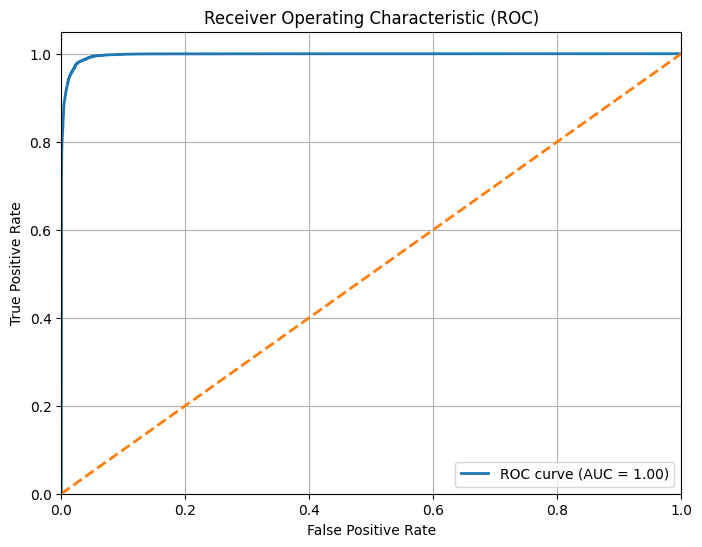

In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ─── Alias your test generator ───────────────────────────────────────────────
# (If yours is already called test_gen, skip this line.)
test_gen = test_generator  

# ─── Ensure no shuffling, and reset pointer ────────────────────────────────────
assert not test_gen.shuffle, "test_gen.shuffle must be False"
test_gen.reset()

# ─── Step 1: True labels ───────────────────────────────────────────────────────
y_true = test_gen.classes            # shape (n_samples,)
n_samples = len(y_true)

# ─── Step 2: Compute steps to cover all samples ───────────────────────────────
steps = math.ceil(n_samples / test_gen.batch_size)

# ─── Step 3: Predict probabilities ────────────────────────────────────────────
y_pred_all = custom_cnn_model.predict(
    test_gen,
    steps=steps,
    verbose=1
)

# ─── Step 4: Extract “positive” class probabilities ──────────────────────────
if y_pred_all.ndim == 2 and y_pred_all.shape[1] == 1:
    # sigmoid output
    y_pred_prob = y_pred_all.ravel()[:n_samples]
elif y_pred_all.ndim == 2 and y_pred_all.shape[1] == 2:
    # softmax output (take column 1)
    y_pred_prob = y_pred_all[:n_samples, 1]
else:
    raise ValueError(f"Unexpected prediction shape: {y_pred_all.shape}")

# ─── Step 5: Compute ROC & AUC ────────────────────────────────────────────────
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ─── Step 6: Plot ROC curve ──────────────────────────────────────────────────
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


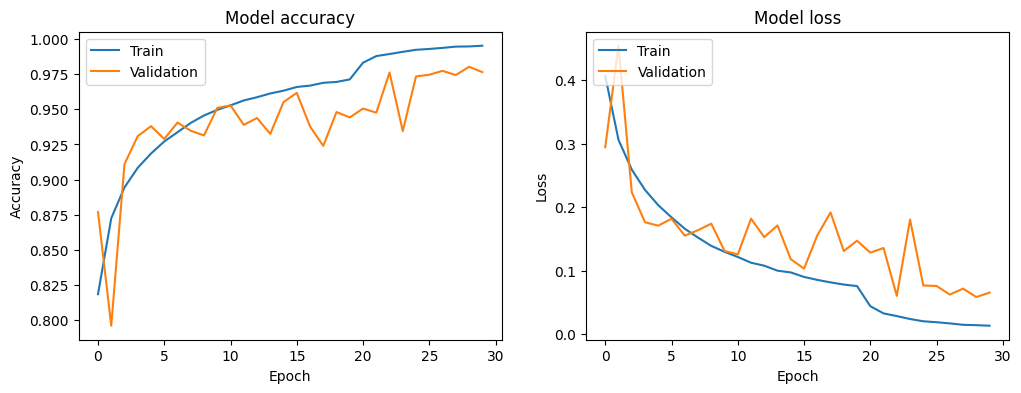

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'])
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
import numpy as np
import math

# Calculate steps to cover the entire test set
num_samples = len(test_gen.classes)
steps = math.ceil(num_samples / test_gen.batch_size)

# Evaluate the model on the test set
test_loss, test_acc = custom_cnn_model.evaluate(test_gen, steps=steps)
print('Test accuracy:', test_acc)

# Predict on the test set
predictions = custom_cnn_model.predict(test_gen, steps=steps)

# Convert predictions to class indices
y_pred = np.argmax(predictions, axis=1)

# Get true labels from the generator
y_true = test_gen.classes

# Trim predictions if they are longer than true labels (due to batch size padding)
y_pred = y_pred[:len(y_true)]



98/98 [==============================] - 72s 730ms/step - loss: 0.0701 - accuracy: 0.9761
Test accuracy: 0.9760500192642212
98/98 [==============================] - 72s 733ms/step


In [27]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import mixed_precision
from sklearn.metrics import classification_report, confusion_matrix

# ─── 1) Re‑enable mixed precision (if you restarted kernel) ────────────────
mixed_precision.set_global_policy('mixed_float16')

# ─── 2) Reset and gather true labels ───────────────────────────────────────
assert not test_gen.shuffle, "test_gen.shuffle must be False"
test_gen.reset()
y_true = test_gen.classes                   # shape (n_samples,)
n_samples = len(y_true)
steps = math.ceil(n_samples / test_gen.batch_size)

# ─── 3) Predict and build y_pred ───────────────────────────────────────────
test_gen.reset()
y_pred_all = custom_cnn_model.predict(test_gen, steps=steps, verbose=1)

# handle both sigmoid (1‑unit) and softmax (2‑unit) outputs
if y_pred_all.ndim == 2 and y_pred_all.shape[1] == 1:
    # binary sigmoid: threshold at 0.5
    y_pred = (y_pred_all.ravel()[:n_samples] > 0.5).astype(int)
elif y_pred_all.ndim == 2 and y_pred_all.shape[1] == 2:
    # categorical softmax: pick class with max prob
    y_pred = np.argmax(y_pred_all[:n_samples], axis=1)
else:
    raise ValueError(f"Unexpected model output shape: {y_pred_all.shape}")

# ─── 4) Classification report ───────────────────────────────────────────────
target_names = list(test_gen.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

98/98 [==============================] - 72s 733ms/step
              precision    recall  f1-score   support

        fake       0.98      0.98      0.98     10000
        real       0.98      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



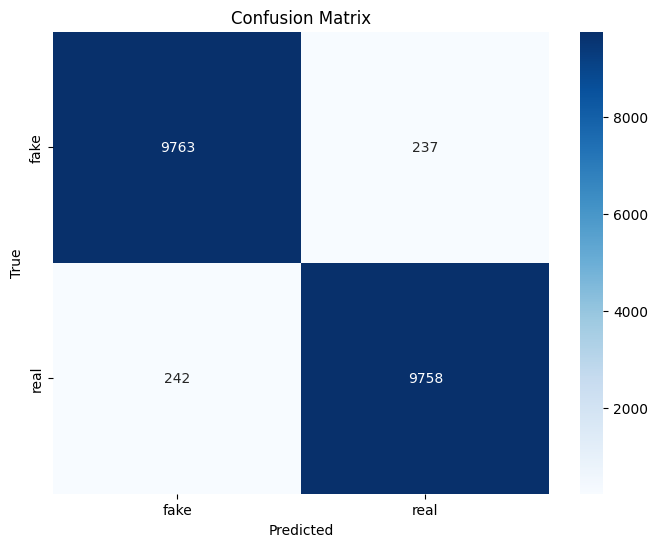

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=target_names, yticklabels=target_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


98/98 [==============================] - 72s 725ms/step


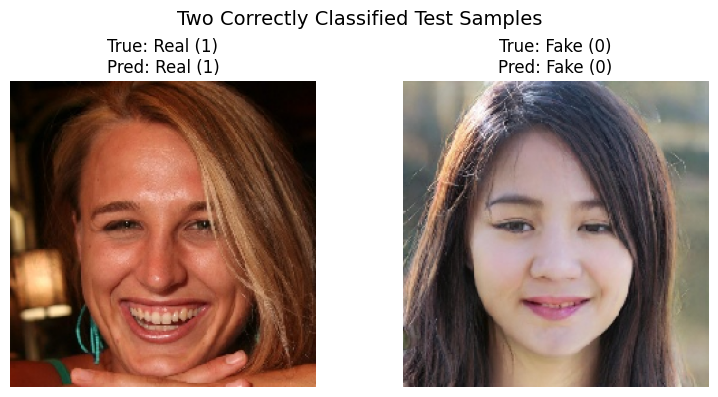

In [32]:
# 6) Get model predictions via the generator, not x_test
test_generator.reset()
y_pred_all = custom_cnn_model.predict(test_generator, steps=steps, verbose=1)
# y_pred_all shape is (n_samples, C) or (n_samples, 1)

# 7) Build y_pred exactly as before
if y_pred_all.ndim == 2 and y_pred_all.shape[1] == 1:
    # sigmoid
    y_pred = (y_pred_all.ravel()[:n_samples] > 0.5).astype(int)
else:
    # softmax
    y_pred = np.argmax(y_pred_all[:n_samples], axis=1)

# 8) (You already have x_test and y_true from before)
#    Find one correct real/fake:
correct_real_idx = np.where((y_true == 1) & (y_pred == 1))[0][0]
correct_fake_idx = np.where((y_true == 0) & (y_pred == 0))[0][0]

# 9) Plot them
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(x_test[correct_real_idx].astype('uint8'))
axes[0].set_title("True: Real (1)\nPred: Real (1)")
axes[0].axis('off')

axes[1].imshow(x_test[correct_fake_idx].astype('uint8'))
axes[1].set_title("True: Fake (0)\nPred: Fake (0)")
axes[1].axis('off')

plt.suptitle("Two Correctly Classified Test Samples", fontsize=14)
plt.tight_layout()
plt.show()


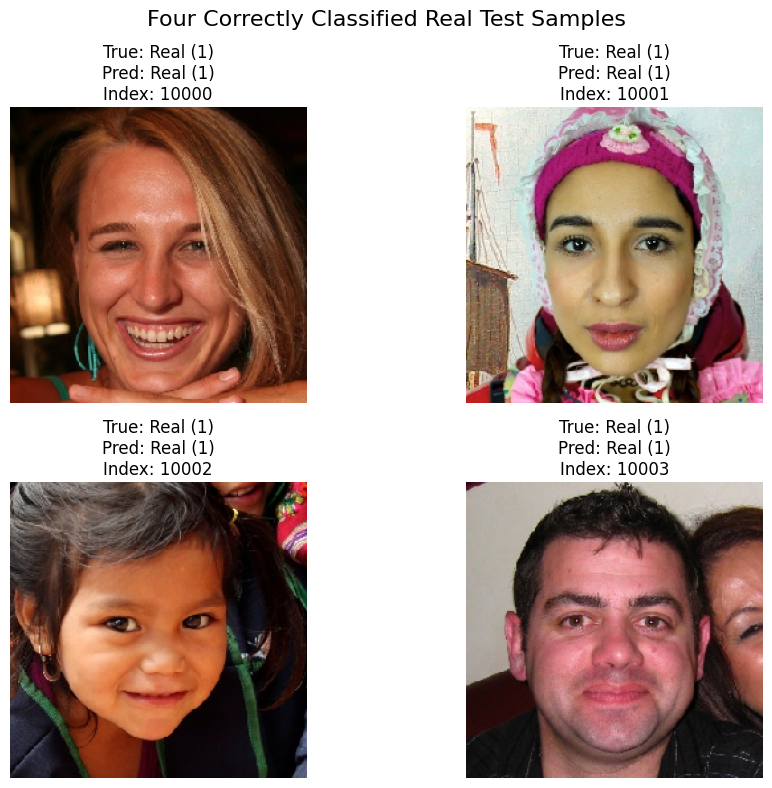

In [36]:
# 8) Find the first four correctly classified real samples
correct_real_idxs = np.where((y_true == 1) & (y_pred == 1))[0][:4]

# 9) Plot those four real examples in a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, idx in enumerate(correct_real_idxs):
    r, c = divmod(i, 2)
    axes[r, c].imshow(x_test[idx].astype('uint8'))
    axes[r, c].set_title(f"True: Real (1)\nPred: Real (1)\nIndex: {idx}")
    axes[r, c].axis('off')

plt.suptitle("Four Correctly Classified Real Test Samples", fontsize=16)
plt.tight_layout()
plt.show()


98/98 [==============================] - 72s 727ms/step


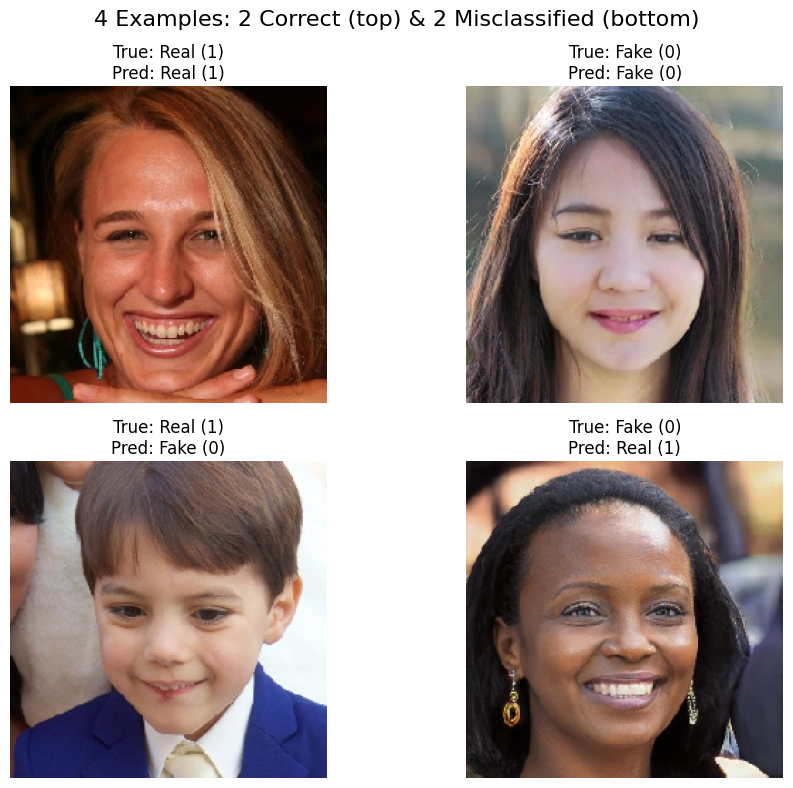

In [34]:
# 6) Get model predictions via the generator
test_generator.reset()
y_pred_all = custom_cnn_model.predict(test_generator, steps=steps, verbose=1)

# 7) Build y_pred as before
if y_pred_all.ndim == 2 and y_pred_all.shape[1] == 1:
    # sigmoid case
    y_pred = (y_pred_all.ravel()[:n_samples] > 0.5).astype(int)
else:
    # softmax case
    y_pred = np.argmax(y_pred_all[:n_samples], axis=1)

# 8) Find the four indices
#   a) correct real  (true=1, pred=1)
correct_real_idx   = np.where((y_true == 1) & (y_pred == 1))[0][0]
#   b) correct fake  (true=0, pred=0)
correct_fake_idx   = np.where((y_true == 0) & (y_pred == 0))[0][0]
#   c) real→fake      (true=1, pred=0)
mis_real_as_fake   = np.where((y_true == 1) & (y_pred == 0))[0][0]
#   d) fake→real      (true=0, pred=1)
mis_fake_as_real   = np.where((y_true == 0) & (y_pred == 1))[0][0]

# 9) Plot all four in a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Top‑left: correct real
axes[0,0].imshow(x_test[correct_real_idx].astype('uint8'))
axes[0,0].set_title("True: Real (1)\nPred: Real (1)")
axes[0,0].axis('off')

# Top‑right: correct fake
axes[0,1].imshow(x_test[correct_fake_idx].astype('uint8'))
axes[0,1].set_title("True: Fake (0)\nPred: Fake (0)")
axes[0,1].axis('off')

# Bottom‑left: mis Real→Fake
axes[1,0].imshow(x_test[mis_real_as_fake].astype('uint8'))
axes[1,0].set_title("True: Real (1)\nPred: Fake (0)")
axes[1,0].axis('off')

# Bottom‑right: mis Fake→Real
axes[1,1].imshow(x_test[mis_fake_as_real].astype('uint8'))
axes[1,1].set_title("True: Fake (0)\nPred: Real (1)")
axes[1,1].axis('off')

plt.suptitle("4 Examples: 2 Correct (top) & 2 Misclassified (bottom)", fontsize=16)
plt.tight_layout()
plt.show()


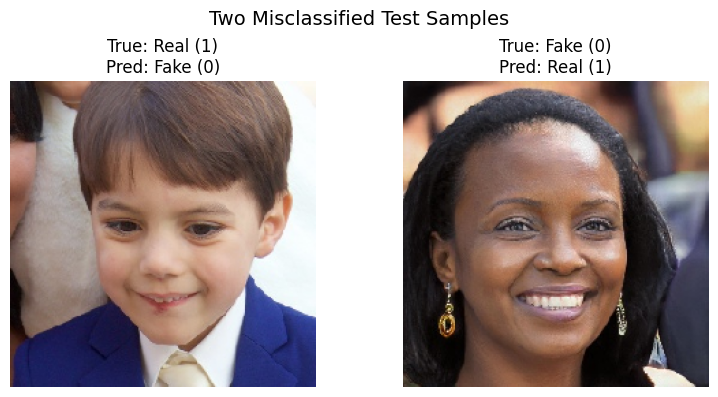

In [33]:
# 8) Find one real → fake misclassification and one fake → real
#    real (1) predicted as fake (0)
mis_real_as_fake_idx = np.where((y_true == 1) & (y_pred == 0))[0][0]
#    fake (0) predicted as real (1)
mis_fake_as_real_idx = np.where((y_true == 0) & (y_pred == 1))[0][0]

# 9) Plot the two misclassified samples
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(x_test[mis_real_as_fake_idx].astype('uint8'))
axes[0].set_title("True: Real (1)\nPred: Fake (0)")
axes[0].axis('off')

axes[1].imshow(x_test[mis_fake_as_real_idx].astype('uint8'))
axes[1].set_title("True: Fake (0)\nPred: Real (1)")
axes[1].axis('off')

plt.suptitle("Two Misclassified Test Samples", fontsize=14)
plt.tight_layout()
plt.show()


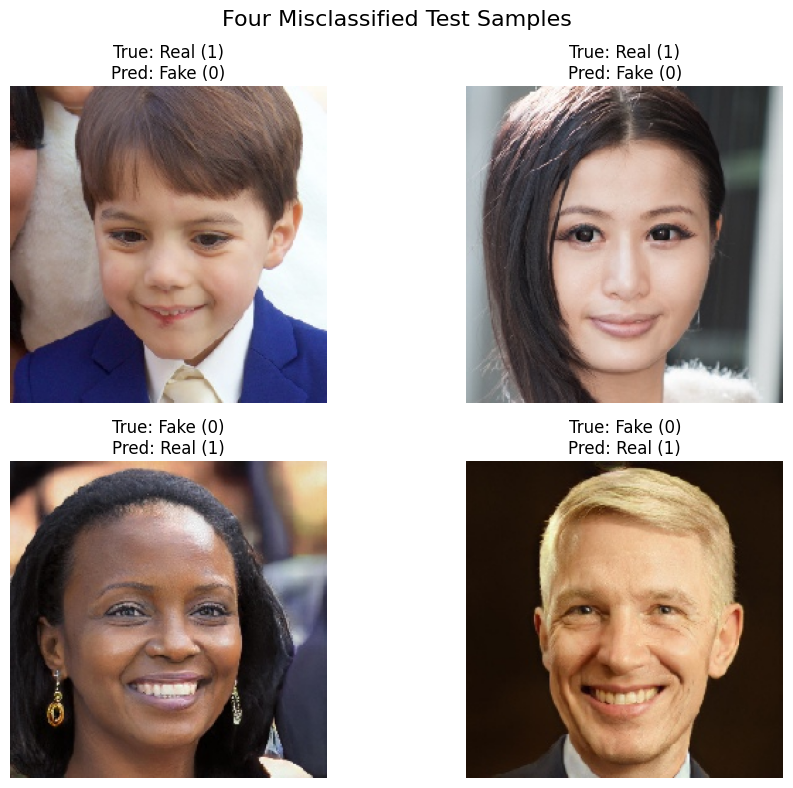

In [35]:
# 8) Find two real→fake and two fake→real misclassifications
mis_real_as_fake = np.where((y_true == 1) & (y_pred == 0))[0][:2]  # first two real→fake
mis_fake_as_real = np.where((y_true == 0) & (y_pred == 1))[0][:2]  # first two fake→real

# 9) Plot all four misclassified samples in a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Top-left: first real→fake
axes[0, 0].imshow(x_test[mis_real_as_fake[0]].astype('uint8'))
axes[0, 0].set_title("True: Real (1)\nPred: Fake (0)")
axes[0, 0].axis('off')

# Top-right: second real→fake
axes[0, 1].imshow(x_test[mis_real_as_fake[1]].astype('uint8'))
axes[0, 1].set_title("True: Real (1)\nPred: Fake (0)")
axes[0, 1].axis('off')

# Bottom-left: first fake→real
axes[1, 0].imshow(x_test[mis_fake_as_real[0]].astype('uint8'))
axes[1, 0].set_title("True: Fake (0)\nPred: Real (1)")
axes[1, 0].axis('off')

# Bottom-right: second fake→real
axes[1, 1].imshow(x_test[mis_fake_as_real[1]].astype('uint8'))
axes[1, 1].set_title("True: Fake (0)\nPred: Real (1)")
axes[1, 1].axis('off')

plt.suptitle("Four Misclassified Test Samples", fontsize=16)
plt.tight_layout()
plt.show()


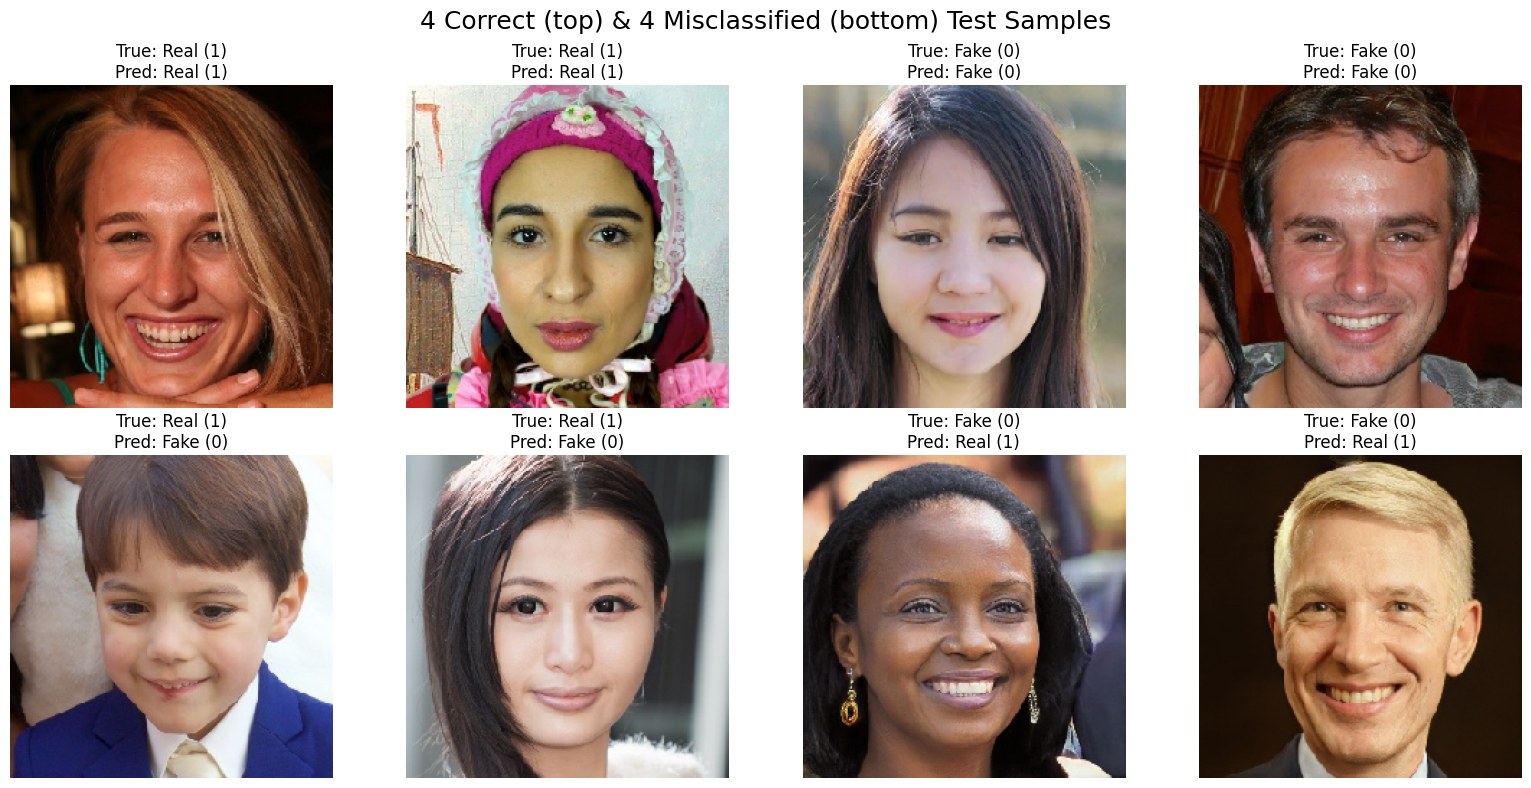

In [39]:
# 8) Collect indices for each case
correct_real_idxs   = np.where((y_true == 1) & (y_pred == 1))[0][:2]
correct_fake_idxs   = np.where((y_true == 0) & (y_pred == 0))[0][:2]
mis_real_as_fake    = np.where((y_true == 1) & (y_pred == 0))[0][:2]
mis_fake_as_real    = np.where((y_true == 0) & (y_pred == 1))[0][:2]

# Combine into two lists of length 4 each
correct_idxs = np.concatenate([correct_real_idxs, correct_fake_idxs])    # 4 correct
mis_idxs     = np.concatenate([mis_real_as_fake, mis_fake_as_real])      # 4 incorrect

# Titles for each
correct_titles = [
    "True: Real (1)\nPred: Real (1)",
    "True: Real (1)\nPred: Real (1)",
    "True: Fake (0)\nPred: Fake (0)",
    "True: Fake (0)\nPred: Fake (0)",
]
mis_titles = [
    "True: Real (1)\nPred: Fake (0)",
    "True: Real (1)\nPred: Fake (0)",
    "True: Fake (0)\nPred: Real (1)",
    "True: Fake (0)\nPred: Real (1)",
]

# 9) Plot in a 2×4 grid
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Top row: correct
for i, (idx, title) in enumerate(zip(correct_idxs, correct_titles)):
    axes[0, i].imshow(x_test[idx].astype('uint8'))
    axes[0, i].set_title(title)
    axes[0, i].axis('off')

# Bottom row: misclassified
for i, (idx, title) in enumerate(zip(mis_idxs, mis_titles)):
    axes[1, i].imshow(x_test[idx].astype('uint8'))
    axes[1, i].set_title(title)
    axes[1, i].axis('off')

plt.suptitle("4 Correct (top) & 4 Misclassified (bottom) Test Samples", fontsize=18)
plt.tight_layout()
plt.show()
